In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Input, Concatenate
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMaker import *

2024-01-16 13:28:07.859121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 13:28:08.628309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
GB_LIMIT = 10

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-16 13:28:12.069811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 13:28:12.147575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 13:28:12.147820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
IMAGE_SHAPE = (5, 64, 64)
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
Z_MAX = 4
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [6]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_validation.hdf5'
TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/ddpm/64x64/5x64x64_testing.hdf5'

In [7]:
# param_names = []
# for i in ['g', 'r', 'i', 'z', 'y']:
#     for j in ['cmodel_mag', 'isophotal_area', 'half_light_radius', 'major_axis', 'minor_axis', 'ellipticity', 'sersic_index', 'peak_surface_brightness']:
#         param_names.append(i + '_' + j)
# v17

param_names = []
for i in ['g', 'r', 'i', 'z', 'y']:
    for j in ['cmodel_mag']:
        param_names.append(i + '_' + j)
        # v19

In [8]:
gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': hparams['batch_size'],
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
val_gen = HDF5ImageGenerator(VAL_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)

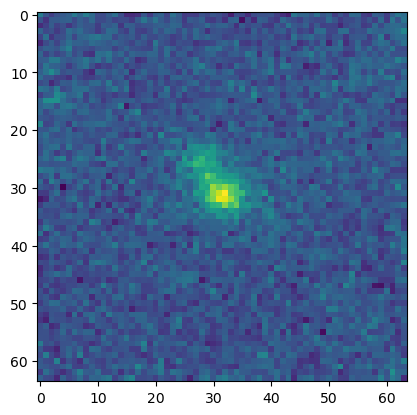

In [9]:
plt.imshow(test_gen[0][0][18][0])

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [17]:
input_cnn = Input(shape=(5,64,64))
# input_nn = Input(shape=(len(param_names),)) # don't forget to change this

# CNN
conv1 = Conv2D(32, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(input_cnn)
pool1 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv1)
conv2 = Conv2D(64, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv2)
conv3 = Conv2D(128, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv3)
conv4 = Conv2D(256, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv4)
conv5 = Conv2D(256, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv5)
conv6 = Conv2D(512, kernel_size = (3, 3),activation = 'relu', padding = 'same', data_format = 'channels_first')(pool5)
conv7 = Conv2D(512, kernel_size = (3, 3),activation = 'relu', padding = 'same', data_format = 'channels_first')(conv6)
flatten = GlobalMaxPooling2D(data_format = 'channels_first')(conv7)
dense1 = Dense(512, activation = 'tanh')(flatten)
dense2 = Dense(128, activation = 'tanh')(dense1)
dense3 = Dense(32, activation = 'tanh')(dense2)

# NN
# hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
# hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
# hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
# hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)
# hidden5 = Dense(hparams['num_dense_units'], activation="relu")(hidden4)
# hidden6 = Dense(hparams['num_dense_units'], activation="relu")(hidden5)

# Concat & Output
# concat = Concatenate()([dense3, hidden6])
output = Dense(1)(dense3)
model = Model(inputs=[input_cnn], outputs=[output])

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 64, 64)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 64, 64)        1472      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 32, 32)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 16, 16)       7385

In [19]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model.fit(train_gen, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=val_gen, callbacks=[])

Epoch 1/100


2024-01-16 13:28:19.486863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-16 13:28:20.639722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-01-16 13:28:20.809530: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 13:28:21.101882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-16 13:28:21.144670: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f7ec01b2cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-16 13:28:21.144692: I tensorflo

KeyboardInterrupt: 

model.load_weights('/data3/Billy/cnn_saved_weights')

In [ ]:
# might take too much memory, use PCA on morphology

In [55]:
TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/ddpm/64x64/5x64x64_testing.hdf5'
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
pred = model.predict(test_gen)

1/8 [==>...........................] - ETA: 0s

2024-01-16 13:36:36.053604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 0s 35ms/step


In [56]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    # oid_test = np.asarray(file['object_id'][:])

In [57]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test, pred[:,0]])).astype('float32')
z = gaussian_kde(xy)(xy)

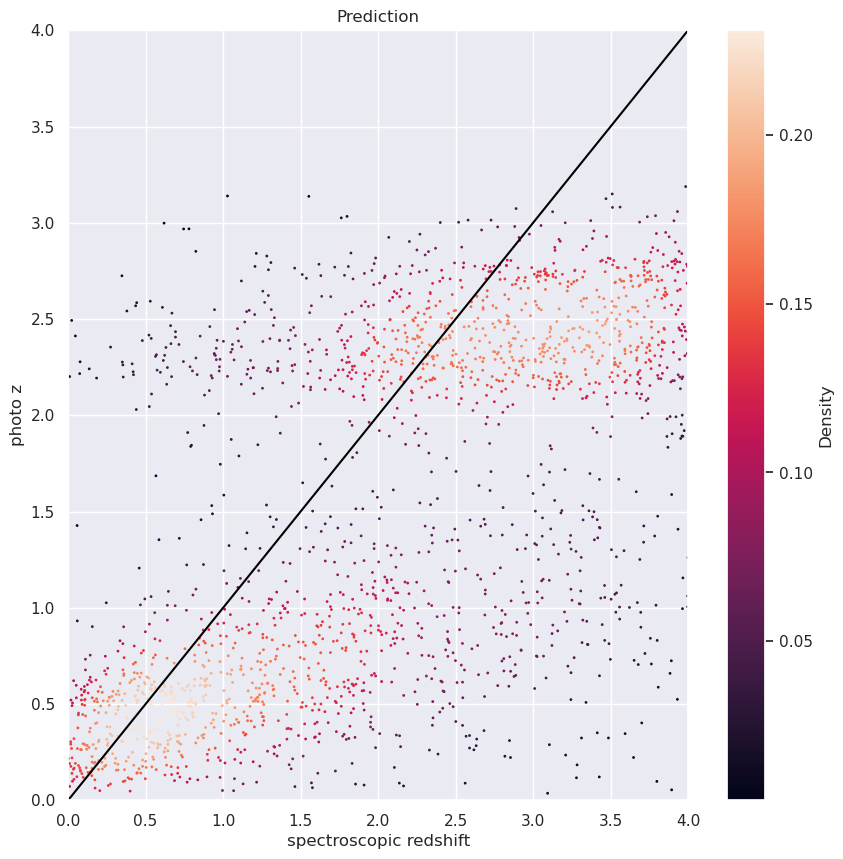

In [58]:
import seaborn as sns
z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, pred[:,0], c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [59]:
metrics_ddpm = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [60]:
metrics_ddpm

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.623191,-0.171399,-0.173167,0.28802,0.263329,0.0745,0.702,1.226924


1/8 [==>...........................] - ETA: 1s

2024-01-16 13:36:43.387122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 0s 26ms/step


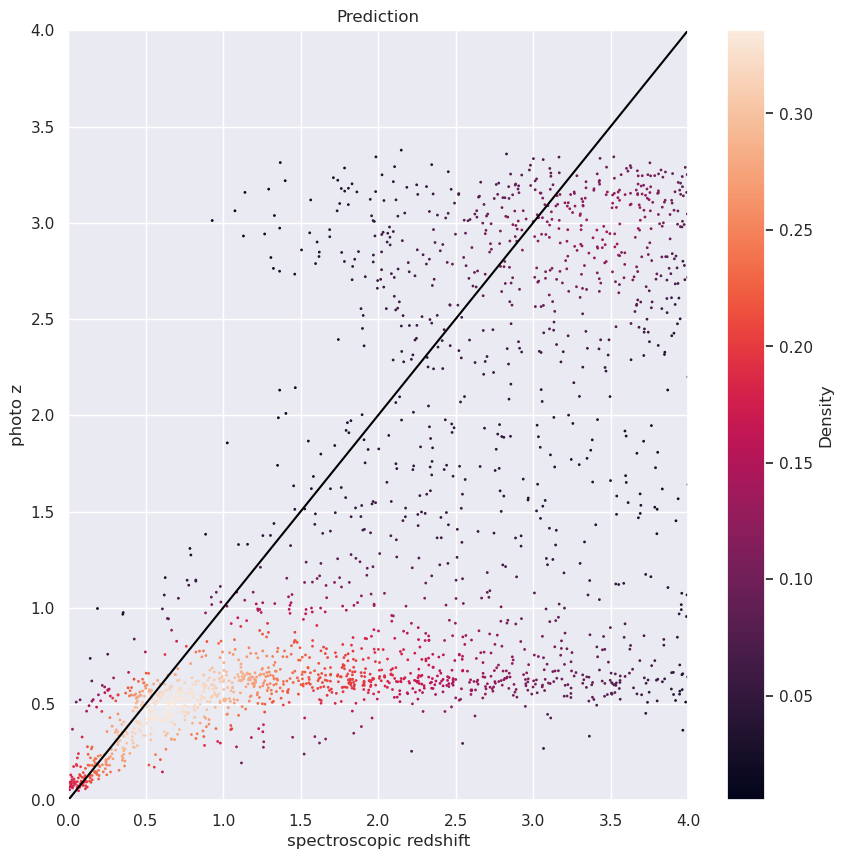

In [61]:
TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/cvae/64x64/5x64x64_testing.hdf5'
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
pred = model.predict(test_gen)
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    # oid_test = np.asarray(file['object_id'][:])
    
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test, pred[:,0]])).astype('float32')
z = gaussian_kde(xy)(xy)

z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, pred[:,0], c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [62]:
metrics_cvae = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [63]:
metrics_cvae

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.585039,-0.201694,-0.182609,0.264131,0.265858,0.03,0.635,1.426806


In [52]:
metrics_ddpm

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.623191,-0.171399,-0.173167,0.28802,0.263329,0.0745,0.702,1.226924


In [ ]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)